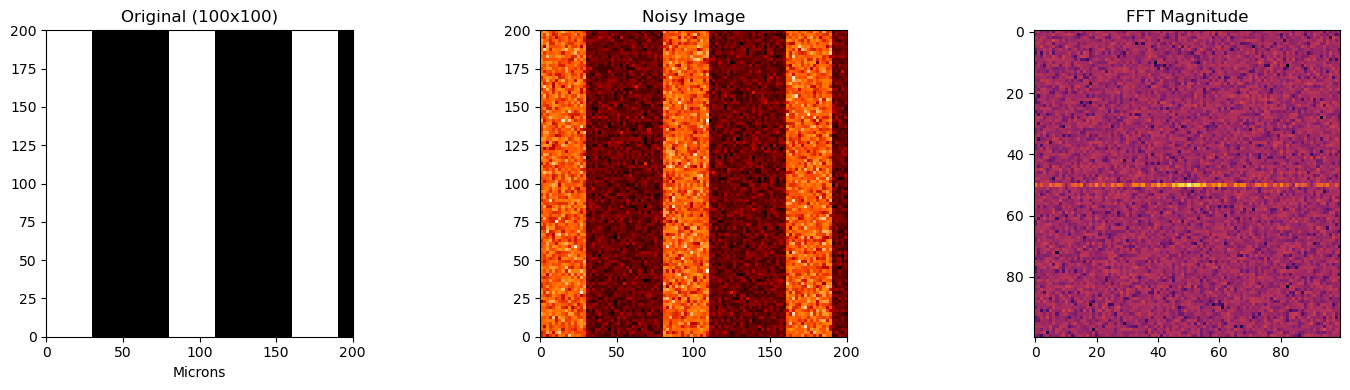

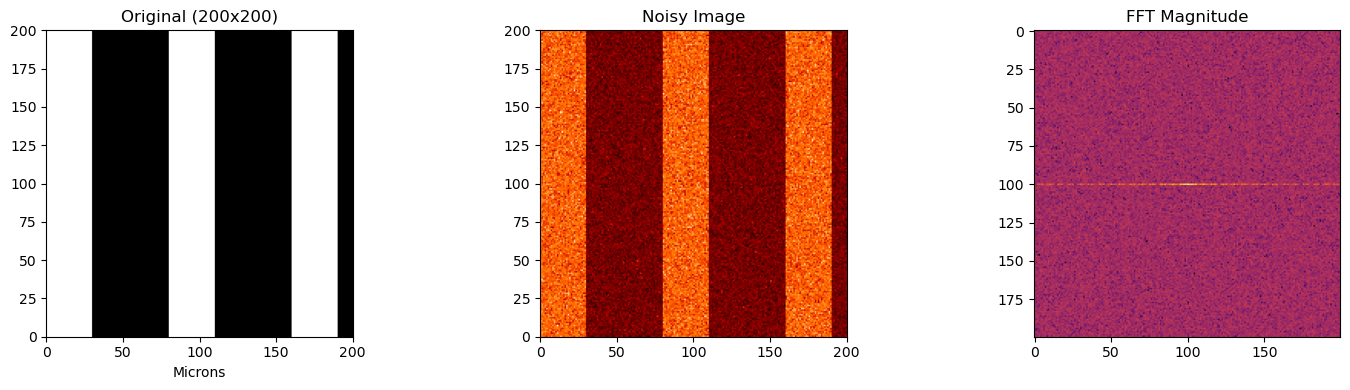

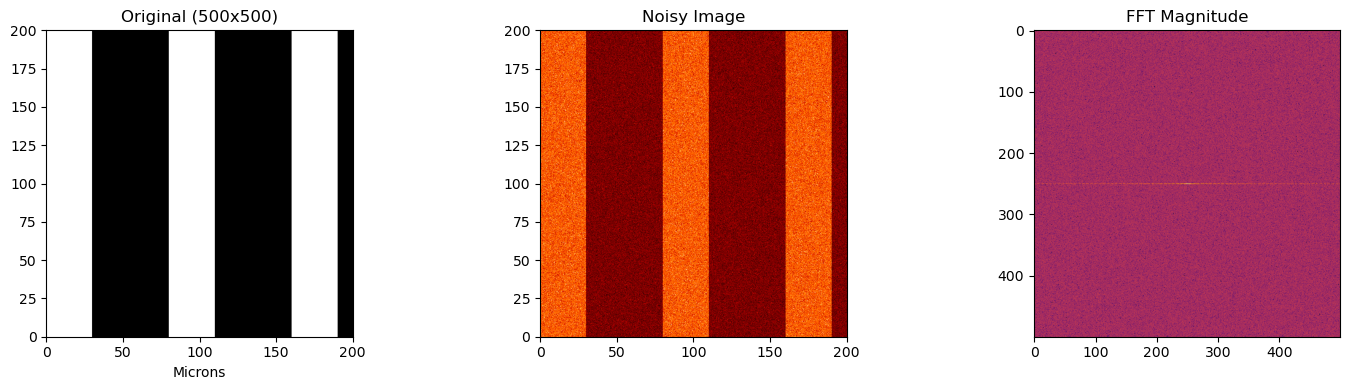

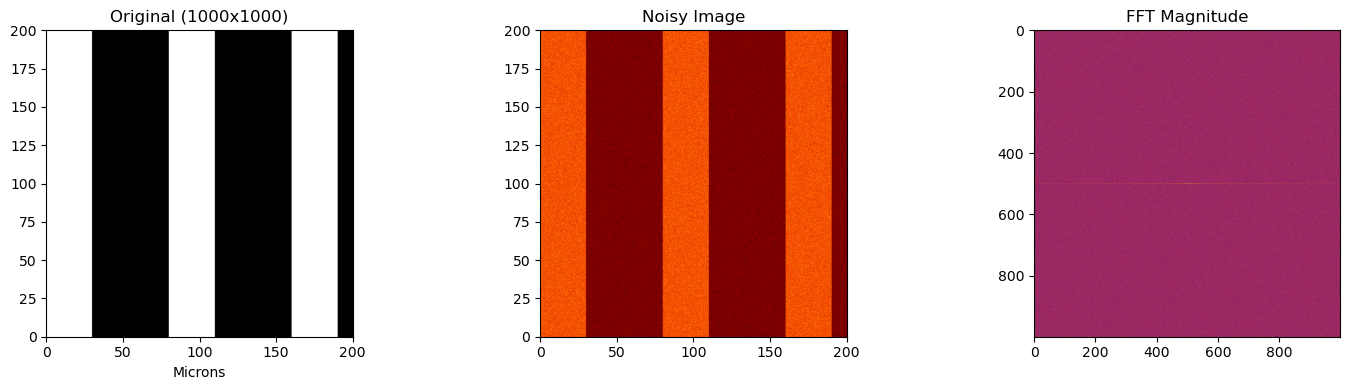

In [48]:
import numpy as np
import matplotlib.pyplot as plt

Area = 200                  
pixel_list = [100, 200, 500, 1000]

bright_width = 30           
dark_width = 50              
cycle_length = bright_width + dark_width

noise_level = 2000

for Pixels in pixel_list:
    x = np.linspace(0, Area, Pixels)
    y = np.linspace(0, Area, Pixels)
    X, Y = np.meshgrid(x, y)

    pattern_mask = (X % cycle_length) < bright_width

    Image = np.zeros((Pixels, Pixels))
    Image[pattern_mask] = 10000
    Image[~pattern_mask] = 500
    
    noise = np.random.normal(0, noise_level, Image.shape)
    Image_noise = Image + noise
        
    F = np.fft.fft2(Image_noise)
    Fshift = np.fft.fftshift(F)
    magnitude_spectrum = 20 * np.log(np.abs(Fshift) + 1)
    
    plt.figure(figsize=(15, 4))

    plt.subplot(131)
    plt.imshow(Image, cmap='gray', extent=[0, Area, 0, Area])
    plt.title(f'Original ({Pixels}x{Pixels})')
    plt.xlabel('Microns')

    plt.subplot(132)
    plt.imshow(Image_noise, cmap='gist_heat', extent=[0, Area, 0, Area])
    plt.title('Noisy Image')

    plt.subplot(133)
    plt.imshow(magnitude_spectrum, cmap='inferno')
    plt.title('FFT Magnitude')

    plt.tight_layout()
    plt.show()



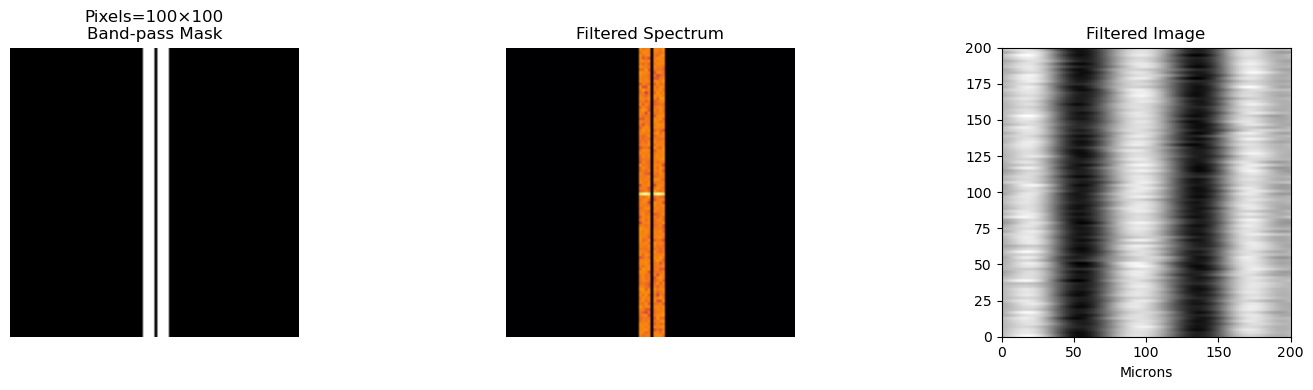

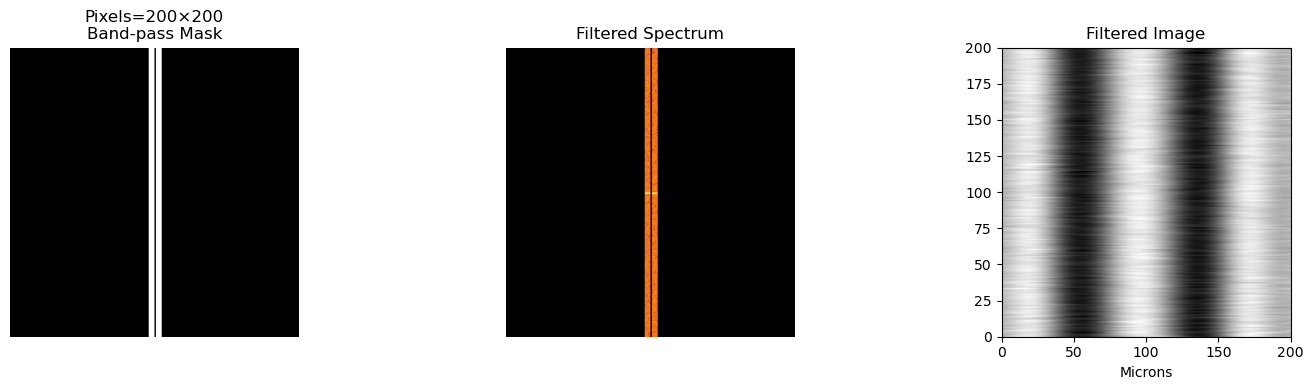

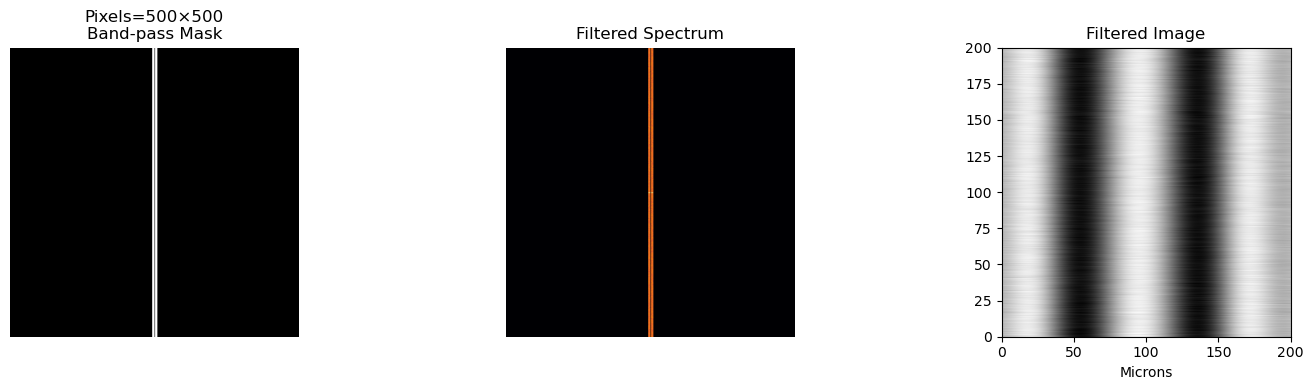

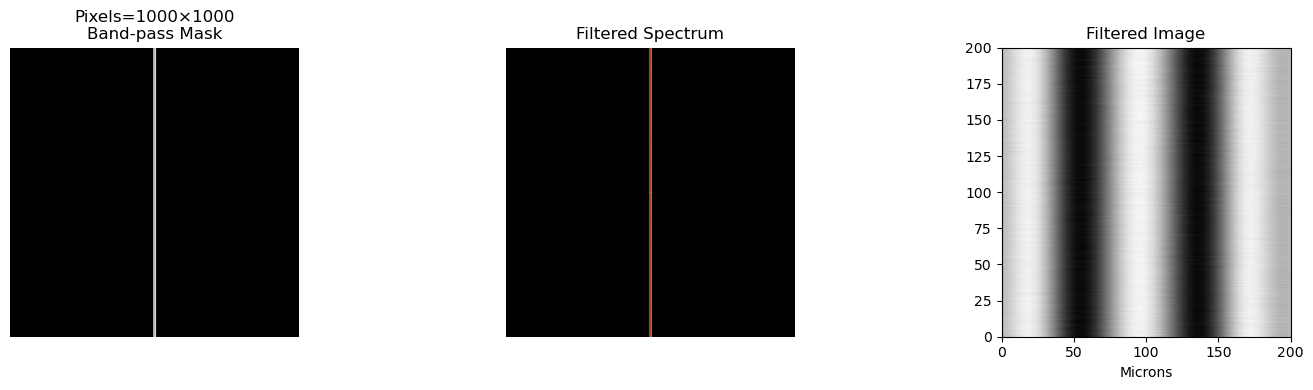

In [51]:
# Fundamental spatial frequency (cycles / micron)
f0 = 1 / cycle_length
bandwidth = 2 / Area        # adjust if needed

np.random.seed(42)             # keep noise identical for all resolutions

# =================================================
# LOOP OVER RESOLUTIONS
# =================================================
for i, Pixels in enumerate(pixel_list):

    # =================================================
    # 1. Spatial Image (re-generate)
    # =================================================
    x = np.linspace(0, Area, Pixels)
    y = np.linspace(0, Area, Pixels)
    X, Y = np.meshgrid(x, y)

    pattern_mask = (X % cycle_length) < bright_width
    Image = np.zeros((Pixels, Pixels))
    Image[pattern_mask] = 10000
    Image[~pattern_mask] = 500

    noise = np.random.normal(0, noise_level, Image.shape)
    Image_noise = Image + noise

    # =================================================
    # 2. FFT
    # =================================================
    F = np.fft.fft2(Image_noise)
    Fshift = np.fft.fftshift(F)

    # =================================================
    # 3. Frequency grid (physical unit)
    # =================================================
    dx = Area / Pixels                       # micron / pixel
    fx = np.fft.fftfreq(Pixels, d=dx)
    fy = np.fft.fftfreq(Pixels, d=dx)
    FX, FY = np.meshgrid(fx, fy)
    FX = np.fft.fftshift(FX)

    # =================================================
    # 4. TRUE Band-pass Filter (1D along X)
    # =================================================
    bandpass_mask = (
        (np.abs(FX) > (f0 - bandwidth)) &
        (np.abs(FX) < (f0 + bandwidth))
    )

    # =================================================
    # 5. Apply filter + IFFT
    # =================================================
    F_filtered = Fshift * bandpass_mask

    img_back = np.fft.ifft2(np.fft.ifftshift(F_filtered))
    img_back = np.real(img_back)

    # =================================================
    # 6. Visualization
    # =================================================
    plt.figure(figsize=(15, 4))

    plt.subplot(131)
    plt.imshow(bandpass_mask, cmap='gray')
    plt.title(f'Pixels={Pixels}×{Pixels}\nBand-pass Mask')
    plt.axis('off')

    plt.subplot(132)
    mag_spec = 20 * np.log(np.abs(F_filtered) + 1)
    plt.imshow(mag_spec, cmap='inferno')
    plt.title('Filtered Spectrum')
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(img_back, cmap='gray', extent=[0, Area, 0, Area])
    plt.title('Filtered Image')
    plt.xlabel('Microns')

    plt.tight_layout()
    plt.show()